# 붓꽃 분류 - Gaussian Naive Bayes 모델

이 글에서는 새로운 측정기기(이하 신규기기)의 측정값과 표준 측정기기(이하 표준기기)의 측정값간의 상관계수가 크고 작음에 따라 신규기기의 유효성이 어떻게 달라지는지 베이지안 추론 방식으로 보여줍니다. 이 글의 전개 과정은 아래와 같습니다. 

1. 성능이 다른 신규기기 두 종류와 하나의 표준기기로 데이터를 수집하고 신규기기/표준기기 데이터를 한 쌍으로 하는 데이터 세트 두 개를 준비합니다.
2. 신규기기/표준기기 데이터 세트에 대한 산포도를 그립니다.
3. 파이썬으로 구현한 코드를 사용하여 각각의 신규기기가 표준기기 측정값을 어느 수준으로 예측할 수 있는지 수치와 그래프로 제시합니다.

## 모델 정의

표준기기를 사용하여 얻는 측정값을 실제값으로 간주합니다. 그리고 **실제값의 변화에 따른 신규기기 측정값의 변화**를 설명하기 위하여 모델을 정의합니다. 여기에서는 실제값이 주어질 때 측정을 여러 번 수행하여 얻는 값들의 발생 가능성은 아래의 정규분포를 따른다고 가정합니다.

* 조사대상군으로부터 수집한 데이터에서 실제값이 속하는 구간의 측정값 평균과 표준편차를 모델로 사용하는 정규분포의 평균과 표준편차로 사용

## 라이브러리 준비

사용할 파이썬 라이브러리들을 임포트합니다.

In [2]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, norm
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(7)

## 데이터 준비

표준기기 **GOLD_STANDARD**와 두 종류의 신규기기 **DEVICE_A**, **DEVICE_B**를 사용하여 데이터를 수집합니다.

* **GOLD_STANDARD**와 **DEVICE_A**의 측정값간의 상관관계: **강함**
* **GOLD_STANDARD**와 **DEVICE_B**의 측정값간의 상관관계: **약함**

### 데이터 파일 형식

* 첫째 줄에는 신규기기의 측정값을 나타내는 `new_device`와 표준기기의 측정값을 나타내는 `gold_standard`를 표시하고 쉼표(,)로 구분합니다. 
* 둘째 줄부터는 각각의 데이터 인스턴스를 한 줄에 표시합니다. 데이터 인스턴스는 신규기기의 측정값과 표준기기의 측정값을 표시하고 쉼표(,)로 구분합니다.

**데이터 파일 예시:**

* dataset_a.csv

    ```
    new_device,gold_standard
    69.94090133881488,284.5262851900178
    51.08601411919196,176.70313147295838
    46.284583871986435,201.64100818392922
    ...
    ```

* dataset_b.csv

    ```
    new_device,gold_standard
    75.54525563680676,284.5262851900178
    78.70545802279494,176.70313147295838
    67.85788950874284,201.64100818392922
    ...
    ```

### 데이터 파일 읽기

In [5]:
def load_data():
    iris = load_iris()
    df_data = pd.DataFrame(iris.data, columns=iris.feature_names)
    df_target = pd.DataFrame(iris.target, columns=['target name'])
    df_iris = pd.concat([df_data, df_target], axis=1)
    return df_iris

df_iris = load_data()

파일로부터 읽은 데이터 앞부분의 내용은 다음과 같습니다.

In [6]:
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target name
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## 데이터 탐색

표준기기의 측정값을 실제값으로 간주하고 `actual`로 표기합니다. 그리고 신규기기의 측정값은 `measured`로 표기합니다. 이는 예측 모델이 수립된 이후부터는 신규기기로 측정을 하고 그 값으로 표준기기의 측정값, 즉 실제값을 추정하기 때문입니다.

### 데이터 통계

In [7]:
df_iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target name
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


### 실제값 및 측정값의 히스토그램

위의 데이터 통계와 산포도를 참고하여 히스토그램을 그리기에 적합한 구간 개수와 값의 범위를 지정합니다.

In [18]:
BINS_MEASURED = 8
RANGE_MEASURED = (0, 8)

세 기기 **GOLD_STANDARD**, **DEVICE_A**, **DEVICE_B**의 측정값들의 분포를 파악하기 위하여 히스토그램을 그립니다.

Text(0.5, 1.0, 'DEVICE_A')

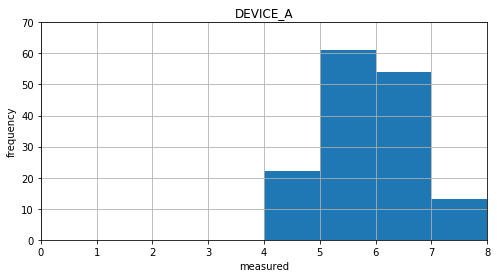

In [22]:
df_iris.hist(column = 'sepal length (cm)', bins = BINS_MEASURED, range = RANGE_MEASURED, figsize = (8, 4))
plt.xlim(RANGE_MEASURED[0], RANGE_MEASURED[1])
plt.ylim(0, 70)
plt.xlabel('measured')
plt.ylabel('frequency')
plt.title('DEVICE_A')

### 실제값 구간별 측정값의 확률분포

표준기기 측정값의 구간별로 신규기기 측정값의 평균과 표준편차를 구하고 이를 사용하여 정규분포 곡선을 그립니다. 이것은 수집한 데이터에 이 글의 앞 부분에서 정의한 모델을 적용하여 실체화된 모델을 얻는 것입니다.

In [15]:
def get_frequency_table(data_measured):
    min = RANGE_ACTUAL[0]
    max = RANGE_ACTUAL[1]
    bin_width = (max - min) / BINS_ACTUAL
    
    frequency_table = {}
    
    for bin_index in np.arange(BINS_ACTUAL):
        frequency_table[bin_index] = []
    
    for i in np.arange(len(data_actual)):
        bin_index = int((data_actual[i] - min) / bin_width)
        frequency_table[bin_index].append(data_measured[i])
        
    return frequency_table

frequency_table_a = get_frequency_table(data_measured_a)
frequency_table_b = get_frequency_table(data_measured_b)

def get_hist_table(frequency_table):
    hist_table = {}
    for bin_index in np.arange(BINS_ACTUAL):
        hist, _ = np.histogram(frequency_table[bin_index], BINS_MEASURED, RANGE_MEASURED)
        hist_table[bin_index] = hist
        
    return hist_table
        
hist_table_a = get_hist_table(frequency_table_a)
hist_table_b = get_hist_table(frequency_table_b)

def get_param_table(frequency_table):
    param_table = {}
    for bin_index in np.arange(BINS_ACTUAL):
        if len(frequency_table[bin_index]) == 0:
            u = np.NaN
            s = np.NaN
        else:
            u = np.mean(frequency_table[bin_index])
            s = np.std(frequency_table[bin_index])
        param_table[bin_index] = [u, s]
        
    return param_table
        
param_table_a = get_param_table(frequency_table_a)
param_table_b = get_param_table(frequency_table_b)

위에서 구한 파라미터 테이블을 바탕으로 표준기기 측정값의 구간별로 신규기기 측정값의 정규분포 곡선을 그려봅니다.

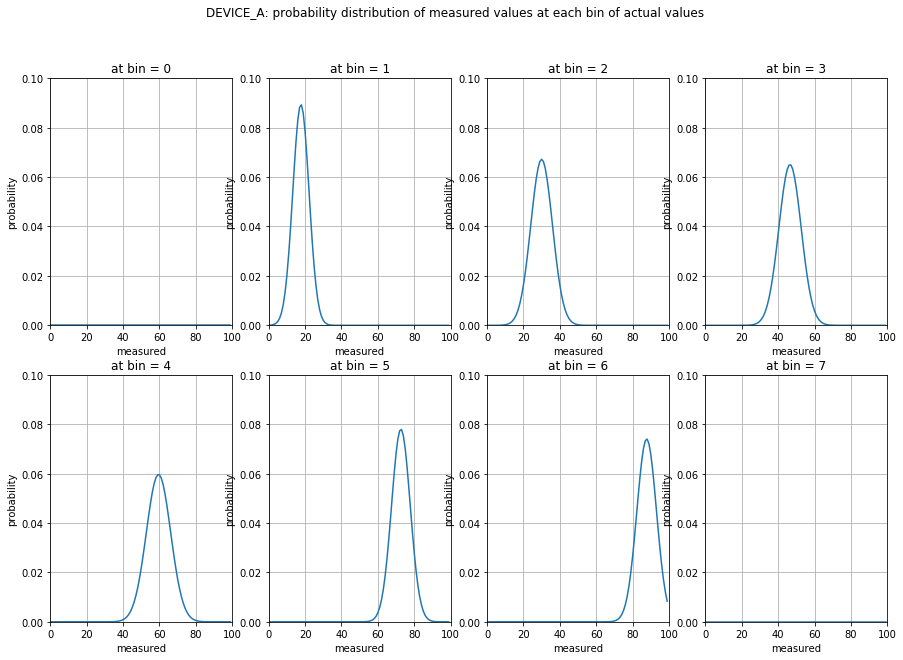

In [16]:
measured_arr = np.linspace(RANGE_MEASURED[0], RANGE_MEASURED[1], 100, endpoint = False)

fig = plt.figure(figsize = (15, 10))
fig.suptitle('DEVICE_A: probability distribution of measured values at each bin of actual values')
for i in np.arange(BINS_ACTUAL):
    u, s = param_table_a[i]
    if np.isnan(u) or np.isnan(s):
        pdf_arr = np.zeros(len(measured_arr))
    else:
        pdf_arr = norm.pdf(measured_arr, u, s)
    
    plt.subplot(241 + i)
    plt.plot(measured_arr, pdf_arr)
    plt.xlim(RANGE_MEASURED[0], RANGE_MEASURED[1])
    plt.ylim(0, 0.1)
    plt.grid(True)
    plt.xlabel('measured')
    plt.ylabel('probability')
    plt.title(f'at bin = {i}')
plt.show()

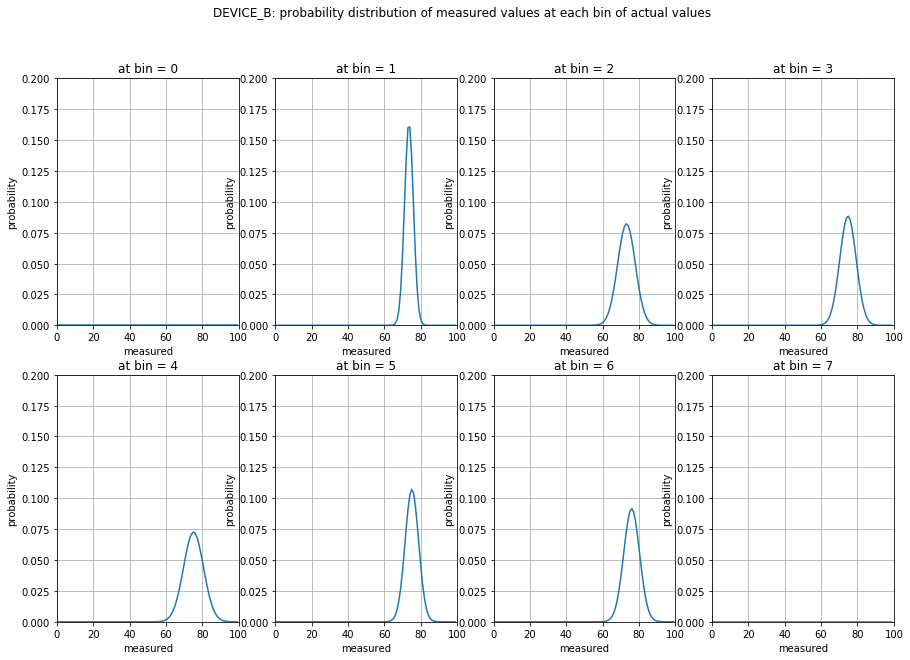

In [17]:
fig = plt.figure(figsize = (15, 10))
fig.suptitle('DEVICE_B: probability distribution of measured values at each bin of actual values')
for i in np.arange(BINS_ACTUAL):
    u, s = param_table_b[i]
    if np.isnan(u) or np.isnan(s):
        pdf_arr = np.zeros(len(measured_arr))
    else:
        pdf_arr = norm.pdf(measured_arr, u, s)

    plt.subplot(241 + i)
    plt.plot(measured_arr, pdf_arr)
    plt.xlim(RANGE_MEASURED[0], RANGE_MEASURED[1])
    plt.ylim(0, 0.2)
    plt.grid(True)
    plt.xlabel('measured')
    plt.ylabel('probability')
    plt.title(f'at bin = {i}')
plt.show()

위의 그래프는 실제값 구간을 지칭하는 `bin_actual`이 증가함에 따라 **DEVICE_A**의 경우에는 측정값 분포의 중심이 오른쪽으로 이동하지만 **DEVICE_B**의 경우는 그렇지 않음을 보여줍니다. 이로부터 다음 두 가지를 알 수 있습니다.

* **DEVICE_A** 측정값의 변화를 통하여 실제값의 변화를 관찰할 수 있다.
* **DEVICE_B** 측정값의 변화로는 실제값의 변화를 관찰하기 어렵다.

### 실제값 구간별 측정값의 상자그림

이번에는 실제값 구간별로 측정값의 상자그림을 그려봅니다. 실제값 구간이 오른쪽으로 이동함에 따라 측정값의 통계가 어떻게 변하는지 더 명확하게 파악할 수 있습니다.

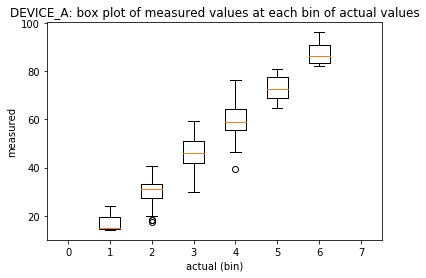

In [18]:
data_for_boxplot = []
labels = []
for i in range(BINS_ACTUAL):
    data_for_boxplot.append(frequency_table_a[i])
    labels.append(i)
plt.boxplot(data_for_boxplot, labels = labels)
plt.xlabel('actual (bin)')
plt.ylabel('measured')
plt.title('DEVICE_A: box plot of measured values at each bin of actual values')
plt.show()

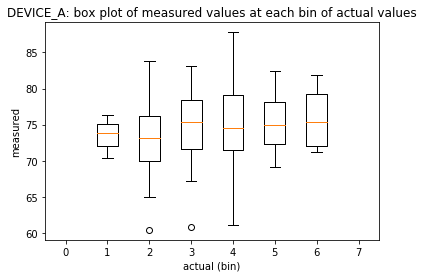

In [19]:
data_for_boxplot = []
labels = []
for i in range(BINS_ACTUAL):
    data_for_boxplot.append(frequency_table_b[i])
    labels.append(i)
plt.boxplot(data_for_boxplot, labels = labels)
plt.xlabel('actual (bin)')
plt.ylabel('measured')
plt.title('DEVICE_A: box plot of measured values at each bin of actual values')
plt.show()

## 베이지안 추론

베이즈 정리에 기반하여 다음과 같이 세 단계를 거쳐 추론하는 것을 베이지안 추론이라고 합니다.

1. 기존의 믿음 (prior belief)
2. 새로운 증거 (new evidence)
3. 믿음의 수정 (update belief -> posterior belief)

### 베이즈 정리

베이즈 정리는 아래의 식으로 표현됩니다.

* $P(H|E) = \frac{P(E|H)\times P(H)}{P(E)}$

위 식에서 각 항목의 의미는 다음과 같습니다.

* $E$ : 사건 (event)
* $H$ : 추론하고자 하는 값 (hypothesis)
* $P(H)$ : E가 발생하기 전의 H에 대한 확률분포 (prior probability distribution)
* $P(E|H)$ : H를 알고 있을 때 E의 발생 가능도 (likelihood)
* $P(E)$ : H에 관계없이 E의  발생 가능도 (marginal likelihood)
* $P(H|E)$ : E가 발생한 후의 H에 대한 확률분포 (posterior probability distribution)

위의 식을 신규기기의 유효성 판단 문제에 적용하기 위하여 E와 H를 다음과 같이 정의합니다.

* E: 신규기기의 측정값 ($v_{measured}$)
* H: 신규기기의 측정값으로부터 추정하는 실제값 ($v_{actual}$)

측정값이 $v_{measured}$일때 **추정**하는 실제값 $v_{actual}$의 확률분포를 아래와 같이 조건부확률로 표현할 수 있습니다.

* $P(v_{actual}|v_{measured})$

이를 베이즈 정리에 따라 표현하면 아래와 같습니다.

* $P(v_{actual}|v_{measured})=\frac { P(v_{measured}|v_{actual})\times P(v_{actual}) }{ P(v_{measured}) }$

위 식의 각 항목에 대한 의미는 다음과 같습니다.

* $P(v_{actual})$ : 측정값을 알기 전의 실제값 $v_{actual}$에 대한 확률분포
* $P(v_{measured}|v_{actual})$ : 실제값이 $v_{actual}$일때 측정값 $v_{measured}$을 얻을 가능도
* $P(v_{measured})$ : 실제값이 무엇이냐에 관계없이 측정값 $v_{measured}$을 얻을 가능도
* $P(v_{actual}|v_{measured})$ : 측정값이 $v_{measured}$일때 **추정**하는 실제값 $v_{actual}$에 대한 확률분포

### 기존의 믿음

조사대상군에 대하여 표준기기로 측정한 값의 분포를 기존의 믿음으로 간주합니다. 즉 어떤 사람을 신규기기로 측정하기 전에는 그의 실제값은 조사대상군에 대하여 표준기기로 측정한 값의 분포를 따른다고 믿는 것입니다. 이를 **사전확률(prior probability)**이라고 합니다.

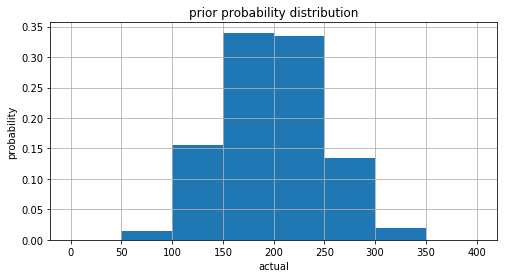

In [20]:
def get_bin_index(bins, range, value):
    min = range[0]
    max = range[1]
    bin_width = (max - min) / bins
    bin_index = int((value - min) / bin_width)
    return bin_index
    
def get_probability(data, bins, range, value):
    hist, bin_edges = np.histogram(data, bins = bins, range = range)
    bin_index = get_bin_index(bins, range, value)
    probability = hist[bin_index] / len(data)
    return probability

def get_prior(actual):
    prior = get_probability(data_actual, BINS_ACTUAL, RANGE_ACTUAL, actual)
    return prior

actual_arr = np.linspace(RANGE_ACTUAL[0], RANGE_ACTUAL[1], BINS_ACTUAL, endpoint = False)
prior_arr = []
for actual in actual_arr:
    prior = get_prior(actual)
    prior_arr.append(prior)
    
plt.figure(figsize = (8, 4))
plt.bar(actual_arr, prior_arr, width = 50, align = 'edge')
plt.grid(True)
plt.xlabel('actual')
plt.ylabel('probability')
plt.title('prior probability distribution')
plt.show()

### 새로운 증거

두 종류의 새로운 측정기기를 사용하여 얻은 값은 다음과 같다고 가정합니다.

* Device A: 70
* Device B: 70

In [21]:
measured_a = 70
measured_b = 70

측정값이 `measured`일 때 실제값이 `actual`일 가능성을 나타내는 **가능도(likelihood)**는 아래와 같이 구합니다.

In [22]:
def get_likelihood(param_table, actual, measured):
    bin_index_actual = get_bin_index(BINS_ACTUAL, RANGE_ACTUAL, actual)
    u, s = param_table[bin_index_actual]
    if np.isnan(u):
        likelihood = 0
    else:
        likelihood = norm.pdf(measured, u, s)
    return likelihood

실제값과 관계없이 `measured` 값을 얻을 가능성을 나타내는 **주변가능도(marginal likelihood)**는 아래와 같이 구합니다.

In [23]:
def get_marginal_likelihood(data_measured, measured):
    marginal_likelihood = 1
    return marginal_likelihood

### 믿음의 수정

**새로운 증거(new evidence)**를 활용하여 **기존의 믿음(prior)**을 수정합니다. 이렇게 얻은 확률을 **사후확률 (posterior)**이라고 부릅니다.

In [24]:
def get_posterior(data_measured, param_table, actual, measured):
    prior = get_prior(actual)
    likelihood = get_likelihood(param_table, actual, measured)
    marginal_likelihood = get_marginal_likelihood(data_measured, measured)
    if marginal_likelihood == 0:
        posterior = 0
    else:
        posterior = likelihood * prior / marginal_likelihood    
    return posterior

`measured` 값이 주어진 상태에서 `actual` 값을 바꾸어 가면서 `posterior`를 구합니다. 그 중에서 최대 `posterior`에 해당하는 `actual`값을 실제값으로 간주합니다. 이 과정을 **Maximum A Posteriori(MAP) 추정**이라고 부릅니다.

In [25]:
def plot_posterior_distribution(data_measured, param_table, measured, title):
    actual_arr = np.linspace(RANGE_ACTUAL[0], RANGE_ACTUAL[1], 400, endpoint = False)
    posterior_arr = []

    for actual in actual_arr:
        posterior = get_posterior(data_measured, param_table, actual, measured)
        posterior_arr.append(posterior)
    
    normalization_factor = np.sum(posterior_arr)
    posterior_arr = posterior_arr / normalization_factor
        
    plt.figure(figsize = (8, 4))

    plt.plot(actual_arr, posterior_arr)
    plt.grid(True)
    plt.xlim(RANGE_ACTUAL[0], RANGE_ACTUAL[1])
    plt.ylim(0, 0.02)
    plt.xlabel('actual')
    plt.ylabel('probability')
    plt.title(title)

    plt.show()

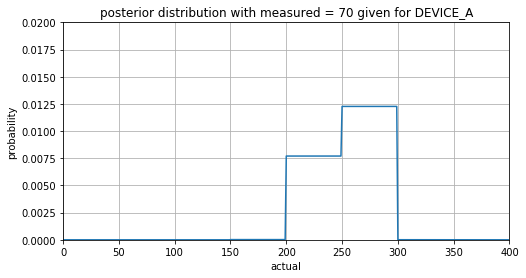

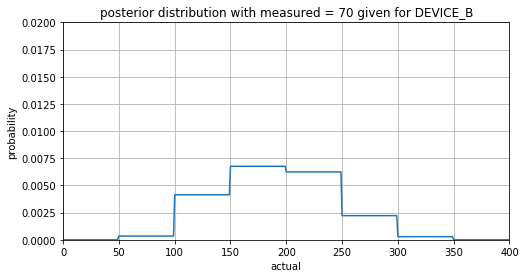

In [26]:
title_a = f'posterior distribution with measured = {measured_a} given for DEVICE_A'
title_b = f'posterior distribution with measured = {measured_b} given for DEVICE_B'
plot_posterior_distribution(data_measured_a, param_table_a, measured_a, title_a)
plot_posterior_distribution(data_measured_b, param_table_b, measured_b, title_b)

위의 사후확률 그래프를 토대로 아래와 같이 말할 수 있습니다.

두 신규기기의 측정값이 각각 70, 70일때

* DEVICE_A:
    * 실제값은 약 0.8의 확률로 250 ~ 300 구간에 속할 것이라 추정
    * 실제값은 약 0.2의 확률로 200 ~ 250 구간에 속할 것이라 추정
* DEVICE_B: 
    * 실제값은 약 0.4의 확률로 150 ~ 200 구간에 속할 것이라 추정
    * 실제값은 약 0.3의 확률로 200 ~ 250 구간에 속할 것이라 추정
    * 실제값은 약 0.15의 확률로 100 ~ 150 구간에 속할 것이라 추정
    * 실제값은 약 0.15의 확률로 250 ~ 300 구간에 속할 것이라 추정

이것은 **DEVICE_A**를 사용하면 **DEVICE_B**를 사용할 때보다 더 강한 자신감을 가지고 실제값을 예측할 수 있음을 나타냅니다.

이번에는 두 신규기기를 사용하여 얻은 값이 다음과 같다고 가정합니다.

* Device A: 60
* Device B: 60

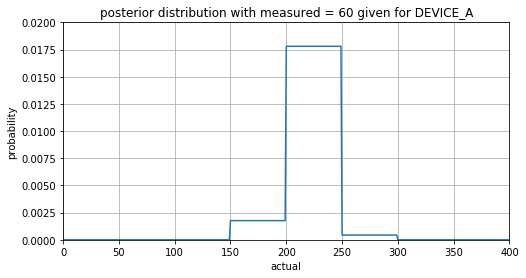

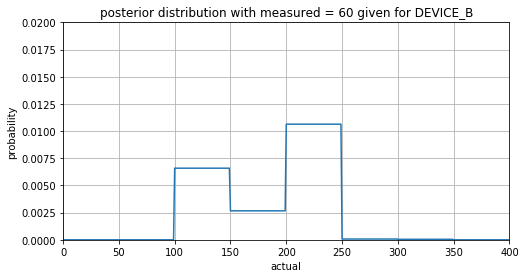

In [27]:
measured_a = 60
measured_b = 60
title_a = f'posterior distribution with measured = {measured_a} given for DEVICE_A'
title_b = f'posterior distribution with measured = {measured_b} given for DEVICE_B'
plot_posterior_distribution(data_measured_a, param_table_a, measured_a, title_a)
plot_posterior_distribution(data_measured_b, param_table_b, measured_b, title_b)

위의 사후확률 그래프를 토대로 아래와 같이 말할 수 있습니다.

두 신규기기의 측정값이 각각 60, 60일때

* DEVICE_A:
    * 실제값은 약 0.75의 확률로 200 ~ 250 구간에 속할 것이라 추정
    * 실제값은 약 0.25의 확률로 250 ~ 300 구간에 속할 것이라 추정
* DEVICE_B: 
    * 실제값은 약 0.24의 확률로 100 ~ 150 구간에 속할 것이라 추정
    * 실제값은 약 0.3의 확률로 150 ~ 200 구간에 속할 것이라 추정
    * 실제값은 약 0.32의 확률로 200 ~ 250 구간에 속할 것이라 추정
    * 실제값은 약 0.14의 확률로 250 ~ 300 구간에 속할 것이라 추정

이것은 **DEVICE_A**를 사용하면 강한 자신감을 가지고 실제값의 구간을 추정할 수 있지만 **DEVICE_B**를 사용할 경우에는 실제값이 어느 구간에 속하는지 말하기 어렵다는 것을 보여줍니다.

## 마무리

* 사례를 통하여 신규기기의 측정값과 표준기기의 측정값간의 상관계수가 크면 상대적으로 신규기기의 유효성이 높게 나오고 상관계수가 작으면 신규기기의 유효성이 낮게 나온다는 것을 확인하였습니다.
* 이 글에서 제시한 방식은 베이지안 분류기에 해당합니다. 분류기의 정확도를 알아보기 위하여 데이터 세트를 훈련용과 테스트용으로 나누고 훈련과 예측을 시도해 볼 수 있습니다.